# Exploratory Analysis
---
In this notebook, we explore the dataset collected from Amazon.

We load the required packages, including functions defined for feature extraction of the book covers:

In [21]:
from matplotlib import pyplot as plt
from feature_extraction import *
from functools import reduce

import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import math

import colorgram
import cv2
import csv
import os
import re

%matplotlib inline

Data and book covers are saved in:

In [22]:
collected_data_folder = './Collected Data/'
original_data_folder = './Original Data/'
image_folder = './Collected Data/Cover Images/'

### Overview

We have chosen to divide the project into the following subtasks:
1. Extract semantically meaningful features of the book covers,
2. Train a model with a good fit of the response variable,
3. Extract information from the model regarding most important features.

Since it is not the aim of the project to use an algorithm that simultanously learns the features and the model at the same time (like Krizhevsky et al.’s ImageNet CNN), we have chosen to first extract the features, and then build a model. This way we also benefit from having interpretable features.

### Extracting features

We are interested in extracting overall features through white-box algorithms for the images. Overall, the following featurs will be extracted:

- Top 2 colors in the image given as one metric storing the information of the RGB value
- Number of unique colors
- Brightness value 
- Entropy value (degree of randomness in the picture)
- Complexity value defined as number of critical points normalized by resolution

**Reading the image**

Get paths of all book covers:

In [23]:
# List of paths of book covers
train_paths = []
for root, dirs, files in os.walk(image_folder):
    for file in files:
        # Ignore hidden files
        if not file.startswith('.'):
            train_paths.append((os.path.join(root, file)))

To be able to stop and continue at will, we will write the computed features to a csv file as we go along. Let's initialize this file with a meaningful header:

In [24]:
with open('features.csv', 'a') as file:
    writer = csv.writer(file)
    writer.writerow(['BookID', 'Brightness', 'Colorfulness', 'Entropy', 'UniqueColors', 'Keypoints',
                     'Color1R', 'Color1G', 'Color1B', 'Color2R', 'Color2G', 'Color2B'])

Load book covers and extract features using pre-defined functions:

In [25]:
# Allocate feature matrix
num_colors = 2
num_features = 5 + num_colors*3
#X = np.zeros((len(train_paths), num_features)) 
IDs = [path[30:40] for path in train_paths]

with open('features.csv', 'a+') as file:
    reader = csv.reader(file)
    writer = csv.writer(file)
    
    # Look at the last scraped book to continue from the next one in the dataset
    file.seek(0)
    last_scraped = next(reversed(list(reader)))[0]
    
    if(last_scraped == 'BookID'):
        # Nothing was scraped yet, start from the beginning
        index = 0
    else:
        # At least one book was scraped, find the index of the last scraped book and start from the next one
        last_scraped_index = IDs.index(last_scraped)
        index = last_scraped_index + 1
        
    count = 0    
    while(index < len(IDs)):
        current_id = IDs[index]

        path = image_folder + current_id + '.jpg'
        image = cv2.imread(path)
        
        # Make sure that unwanted image files does not corrupt
        if image is None:
            continue
        
        X = []
        
        # Book ID
        X.append(path[30:40])
        
        # Exract brightness of image
        X.append(calculate_brightness(image))

        # Extract colorfulness metric of image
        X.append(calculate_colorfulness(image))

        # Calculate image entropy as a measure of degree of randomness
        X.append(calculate_entropy(image))

        # Compute number of unique colors in image
        X.append(calculate_num_unique_colors(image))

        # Calculate number of keypoints in image
        X.append(calculate_num_norm_keypoints(image))

        # Extract RGB color codes of top 2 dominant colors of image
        X = np.r_[X, calculate_top_colors(path, num_colors)]
        
        # Write to file
        writer.writerow(X)
            
        file.flush()

        index += 1
        count += 1    
        
        # Clean the previous line while printing info about scraping progress
        print(f'Number of scraped books: {count}', end='\r')
        

KeyboardInterrupt: 

We create a dataframe and inspect the top rows:

In [ ]:
# Create dataframe
covers = pd.DataFrame(X, columns=['Brightness', 'Colorfulness', 'Entropy', 'UniqueColors', 
                                  'Keypoints', 'Color1R', 'Color1G', 'Color1B', 'Color2R', 'Color2G', 'Color2B'])

# Add book IDs
covers['ID'] = IDs[0:1000]

# Rearrange order of columns
new_order = [11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
covers = covers[covers.columns[new_order]]

# Top rows
covers.head()

#### Merging the datasets

We now merge the book cover features with the remaining two datasets. First, we load them:

In [10]:
# Load scraped data
scraped = pd.read_csv(collected_data_folder + 'scraped.csv', sep=',')

# Load original book dataset with header names
header_names = ['ID', 'Filename', 'Image URL', 'Title', 'Author', 'Category ID', 'Category']
original = pd.read_csv(original_data_folder + 'book32-listing.csv', encoding='latin1', header=None, names=header_names)

For some reason, the ID column in the original dataset has the leading 0s removed (normally all of them should be 10 characters long). The filename column has the correct IDs with the correct number of leading 0s. So let's use the Filename column as the new ID column:

In [11]:
original['ID'] = original['Filename'].apply(lambda row: re.findall(u'(.*).jpg', row)[0])
original.drop(columns='Filename', inplace=True)
original.head()

,ID,Image URL,Title,Author,Category ID,Category
0,0761183272,http://ecx.images-amazon.com/images/I/61Y5cOdH...,Mom's Family Wall Calendar 2016,Sandra Boynton,3,Calendars
1,1623439671,http://ecx.images-amazon.com/images/I/61t-hrSw...,Doug the Pug 2016 Wall Calendar,Doug the Pug,3,Calendars
2,B00O80WC6I,http://ecx.images-amazon.com/images/I/41X-KQqs...,"Moleskine 2016 Weekly Notebook, 12M, Large, Bl...",Moleskine,3,Calendars
3,0761182187,http://ecx.images-amazon.com/images/I/61j-4gxJ...,365 Cats Color Page-A-Day Calendar 2016,Workman Publishing,3,Calendars
4,1578052084,http://ecx.images-amazon.com/images/I/51Ry4Tsq...,Sierra Club Engagement Calendar 2016,Sierra Club,3,Calendars


Now we inspect the top rows to make sure that nothing is corrupted:

In [12]:
scraped.head()

,ID,Sales Rank,Date,Review Score
0,0545790352,118,"October 6, 2015",4.77
1,1419717014,399,"November 3, 2015",4.8
2,1423160916,9637,"October 6, 2015",4.6
3,1476789886,5439,"October 27, 2015",4.9
4,1338029991,196,"November 10, 2015",4.61


In [13]:
original.head()

,ID,Image URL,Title,Author,Category ID,Category
0,0761183272,http://ecx.images-amazon.com/images/I/61Y5cOdH...,Mom's Family Wall Calendar 2016,Sandra Boynton,3,Calendars
1,1623439671,http://ecx.images-amazon.com/images/I/61t-hrSw...,Doug the Pug 2016 Wall Calendar,Doug the Pug,3,Calendars
2,B00O80WC6I,http://ecx.images-amazon.com/images/I/41X-KQqs...,"Moleskine 2016 Weekly Notebook, 12M, Large, Bl...",Moleskine,3,Calendars
3,0761182187,http://ecx.images-amazon.com/images/I/61j-4gxJ...,365 Cats Color Page-A-Day Calendar 2016,Workman Publishing,3,Calendars
4,1578052084,http://ecx.images-amazon.com/images/I/51Ry4Tsq...,Sierra Club Engagement Calendar 2016,Sierra Club,3,Calendars


It looks fine for now, so we continue to merge the all the datasets using the book IDs as our primary key: 

In [14]:
dfs = [covers, original, scraped]
books = reduce(lambda left,right: pd.merge(left,right,on='ID'), dfs)
books.head()

,ID,Brightness,Colorfulness,Entropy,UniqueColors,Keypoints,Color1R,Color1G,Color1B,Color2R,Color2G,Color2B,Image URL,Title,Author,Category ID,Category,Sales Rank,Date,Review Score
0,1442496797,0.525140,122.037335,6.843093,56732.0,0.018625,4.0,185.0,197.0,3.0,90.0,108.0,http://ecx.images-amazon.com/images/I/51M%2BHR...,The Case of the Weird Blue Chicken: The Next M...,Doreen Cronin,4,Children's Books,878409,"September 30, 2014",4.78
1,0375824308,0.508363,62.399971,7.407145,95994.0,0.024494,180.0,163.0,120.0,41.0,135.0,101.0,http://ecx.images-amazon.com/images/I/51D%2BOM...,Sergei Prokofiev's Peter and the Wolf: With a ...,Sergei Prokofiev,4,Children's Books,NaN,NaN,NaN
2,0395899257,0.841409,112.527855,3.904536,43675.0,0.007876,252.0,252.0,76.0,252.0,252.0,244.0,http://ecx.images-amazon.com/images/I/51frwULt...,Curious George's ABCs,H. A. Rey,4,Children's Books,639464,"March 30, 1998",4.59
3,0310730953,0.467417,60.502088,7.734455,77720.0,0.035227,74.0,89.0,154.0,180.0,161.0,136.0,http://ecx.images-amazon.com/images/I/61RXLmOT...,Our Presidents Rock!,Juliette Turner,4,Children's Books,194747,"September 30, 2014",4.8
4,0062430610,0.482754,93.746543,7.128056,90600.0,0.026224,165.0,26.0,45.0,216.0,141.0,179.0,http://ecx.images-amazon.com/images/I/610syR1P...,Pete the Cat's Groovy Guide to Love,James Dean,4,Children's Books,NaN,NaN,NaN


We only have Children's Books so we don't need the Category or Category ID columns anymore:

In [15]:
books.drop(columns=['Category ID', 'Category'], inplace=True)
books.head()

,ID,Brightness,Colorfulness,Entropy,UniqueColors,Keypoints,Color1R,Color1G,Color1B,Color2R,Color2G,Color2B,Image URL,Title,Author,Sales Rank,Date,Review Score
0,1442496797,0.525140,122.037335,6.843093,56732.0,0.018625,4.0,185.0,197.0,3.0,90.0,108.0,http://ecx.images-amazon.com/images/I/51M%2BHR...,The Case of the Weird Blue Chicken: The Next M...,Doreen Cronin,878409,"September 30, 2014",4.78
1,0375824308,0.508363,62.399971,7.407145,95994.0,0.024494,180.0,163.0,120.0,41.0,135.0,101.0,http://ecx.images-amazon.com/images/I/51D%2BOM...,Sergei Prokofiev's Peter and the Wolf: With a ...,Sergei Prokofiev,NaN,NaN,NaN
2,0395899257,0.841409,112.527855,3.904536,43675.0,0.007876,252.0,252.0,76.0,252.0,252.0,244.0,http://ecx.images-amazon.com/images/I/51frwULt...,Curious George's ABCs,H. A. Rey,639464,"March 30, 1998",4.59
3,0310730953,0.467417,60.502088,7.734455,77720.0,0.035227,74.0,89.0,154.0,180.0,161.0,136.0,http://ecx.images-amazon.com/images/I/61RXLmOT...,Our Presidents Rock!,Juliette Turner,194747,"September 30, 2014",4.8
4,0062430610,0.482754,93.746543,7.128056,90600.0,0.026224,165.0,26.0,45.0,216.0,141.0,179.0,http://ecx.images-amazon.com/images/I/610syR1P...,Pete the Cat's Groovy Guide to Love,James Dean,NaN,NaN,NaN


In [16]:
books.shape

(1000, 18)

Ta-da! It looks fine, so we proceed with the exploratory analysis.

#### Exploring the dataset

We check the different types:

In [17]:
books.dtypes

ID               object
Brightness      float64
Colorfulness    float64
Entropy         float64
UniqueColors    float64
Keypoints       float64
Color1R         float64
Color1G         float64
Color1B         float64
Color2R         float64
Color2G         float64
Color2B         float64
Image URL        object
Title            object
Author           object
Sales Rank       object
Date             object
Review Score     object
dtype: object

Let's convert the RGB columns from floats to integers: 

In [18]:
# Most dominant color
books['Color1R'] = books['Color1R'].astype(int)
books['Color1G'] = books['Color1G'].astype(int)
books['Color1B'] = books['Color1B'].astype(int)

# Second-most dominant color
books['Color2R'] = books['Color2R'].astype(int)
books['Color2G'] = books['Color2G'].astype(int)
books['Color2B'] = books['Color2B'].astype(int)

..and the Date column into datetime:

In [19]:
books['Date'] = pd.to_datetime(books['Date'])

Also, the sales rank and the review score are stored as categorical features. Let's convert them to numerical ones:

In [20]:
books['Sales Rank'] = books['Sales Rank'].astype(float)
books['Sales Rank'].head()

0    878409.0
1         NaN
2    639464.0
3    194747.0
4         NaN
Name: Sales Rank, dtype: float64

In [21]:
books['Review Score'] = books['Review Score'].astype(float)
books['Review Score'].head()

0    4.78
1     NaN
2    4.59
3    4.80
4     NaN
Name: Review Score, dtype: float64

We see that we have a few missing values. Let's check how many we have:

In [22]:
books.isnull().sum()[books.isnull().sum() > 0]

Author           26
Sales Rank      156
Date            156
Review Score    151
dtype: int64

We check if the missing values occur in the same rows: 

In [23]:
missing = books[books['Sales Rank'].isna() & books['Date'].isna() & books['Review Score'].isna()]
missing

,ID,Brightness,Colorfulness,Entropy,UniqueColors,Keypoints,Color1R,Color1G,Color1B,Color2R,Color2G,Color2B,Image URL,Title,Author,Sales Rank,Date,Review Score
1,0375824308,0.508363,62.399971,7.407145,95994.0,0.024494,180,163,120,41,135,101,http://ecx.images-amazon.com/images/I/51D%2BOM...,Sergei Prokofiev's Peter and the Wolf: With a ...,Sergei Prokofiev,NaN,NaT,NaN
4,0062430610,0.482754,93.746543,7.128056,90600.0,0.026224,165,26,45,216,141,179,http://ecx.images-amazon.com/images/I/610syR1P...,Pete the Cat's Groovy Guide to Love,James Dean,NaN,NaT,NaN
7,158925628X,0.514915,94.653258,7.491768,124127.0,0.016215,228,141,66,21,113,162,http://ecx.images-amazon.com/images/I/512CK8nT...,Bedtime in the Meadow (Padded Board Books),Stephanie Shaw,NaN,NaT,NaN
9,0064440737,0.705346,89.361788,7.259133,66526.0,0.023922,238,219,94,252,245,219,http://ecx.images-amazon.com/images/I/51DjurhI...,The Horse in Harry's Room (Level 1),Syd Hoff,NaN,NaT,NaN
12,1846866642,0.535556,119.614705,7.160937,114162.0,0.027578,78,187,232,235,151,45,http://ecx.images-amazon.com/images/I/61CubMgc...,Driving My Tractor PB w CDEX (A Barefoot Singa...,Jan Dobbins,NaN,NaT,NaN
23,0688161677,0.473716,61.152168,6.826779,106645.0,0.023487,113,116,88,135,150,84,http://ecx.images-amazon.com/images/I/519oSH24...,Bat Jamboree,Kathi Appelt,NaN,NaT,NaN
40,0545773547,0.452968,79.044642,7.467801,119105.0,0.033700,44,103,158,98,175,208,http://ecx.images-amazon.com/images/I/51JG2hs%...,Race the Wild #2: Great Reef Games,Kristin Earhart,NaN,NaT,NaN
41,0316256749,0.199709,80.135955,6.300792,42506.0,0.014419,15,12,11,166,14,33,http://ecx.images-amazon.com/images/I/51LnVBH%...,Marvel's Ant-Man: The Junior Novel,Chris Wyatt,NaN,NaT,NaN
46,1250052157,0.534279,93.691481,6.929651,62414.0,0.023568,153,189,54,174,178,65,http://ecx.images-amazon.com/images/I/51ZbS5Zk...,My Big Fat Zombie Goldfish,Mo O'Hara,NaN,NaT,NaN
48,0545143152,0.723407,65.709298,6.264026,67230.0,0.023453,253,233,144,210,153,71,http://ecx.images-amazon.com/images/I/51L8WWSp...,How Do Dinosaurs Say I'm Mad!,Jane Yolen,NaN,NaT,NaN


In [24]:
len(missing)

151

As we will treat the sales rank as our response variable, we decide to drop rows for which it is missing:

In [25]:
books.dropna(inplace=True)

Now, let's inspect summary statistics for the numerical features:

In [26]:
books.describe()

,Brightness,Colorfulness,Entropy,UniqueColors,Keypoints,Color1R,Color1G,Color1B,Color2R,Color2G,Color2B,Sales Rank,Review Score
count,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,824.000000,8.240000e+02,824.000000
mean,0.581184,68.472712,6.737558,69496.635922,0.023972,165.718447,163.351942,148.814320,154.865291,146.030340,126.934466,6.367167e+05,4.403167
std,0.146405,27.578155,1.017007,27181.300800,0.011052,80.609545,75.378623,80.238713,76.697414,71.269825,74.383660,1.673790e+06,0.986517
min,0.109715,5.314949,1.948720,3490.000000,0.002561,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.800000e+01,0.000000
25%,0.485932,48.990829,6.341084,50941.250000,0.015728,108.000000,97.000000,73.000000,97.000000,89.000000,65.000000,2.087850e+04,4.450000
50%,0.582868,64.092237,7.065358,67289.500000,0.023107,189.000000,172.000000,162.000000,177.000000,158.000000,117.000000,9.761450e+04,4.670000
75%,0.688469,86.168348,7.445192,86732.000000,0.030613,242.000000,232.000000,227.000000,224.000000,213.250000,199.250000,4.811865e+05,4.790000
max,0.947713,183.419653,7.941739,150687.000000,0.068457,254.000000,254.000000,253.000000,254.000000,254.000000,254.000000,1.754868e+07,5.000000


..and also for the categorical ones:

In [27]:
books.describe(include=[np.object])

,ID,Image URL,Title,Author
count,824,824,824,824
unique,824,823,823,591
top,0764168134,http://ecx.images-amazon.com/images/I/51UTugqy...,The Runaway Bunny,H. A. Rey
freq,1,2,2,13


We start with examining the distribution of the response variable `Sales Rank` through a boxplot:

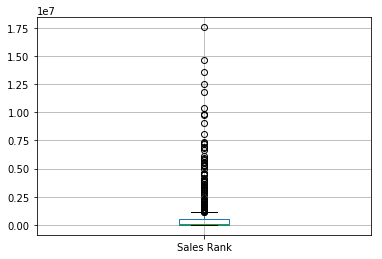

In [28]:
books.boxplot(column='Sales Rank');

It seems that we have few books that are very popular, and a lot of books that are not. Could this be a power law?

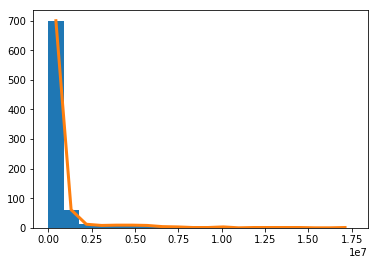

In [29]:
num_bins = 20

y, bin_edges = np.histogram(books['Sales Rank'], num_bins)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])

plt.hist(books['Sales Rank'], num_bins);
plt.plot(bin_centers, y, lw=3);
#plt.xlabel('x');
#plt.ylabel('Sales Rank');

Let's inspect a log-log histogram:

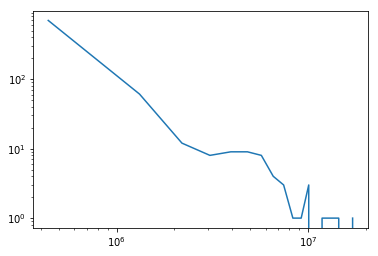

In [30]:
plt.loglog(bin_centers, y);
#plt.xlabel('x');
#plt.ylabel('Sales Rank');

It roughly looks like one, with the linear part at the beginning and the noise at the end! Let's also look at the cumulative distribution to confirm.

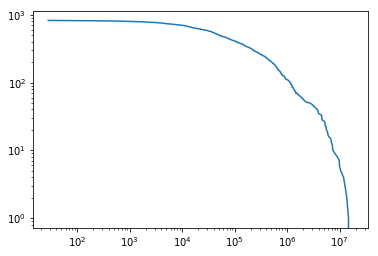

In [31]:
sales = np.sort(books['Sales Rank'].values)[::-1]
ranks = range(len(sales))
plt.loglog(sales, ranks);
#plt.xlabel('x');
#plt.ylabel('#tags that appear in over x questions');

We are not completely convinced. We also examine the relationship between `Review Score` and `Sales Rank`:

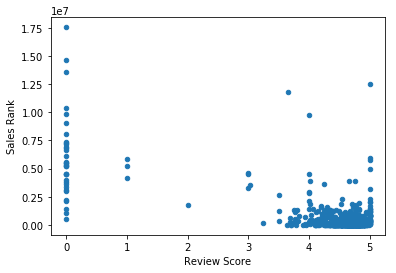

In [32]:
books.plot.scatter(x='Review Score',y='Sales Rank');

A correlation between `Review Score` and `Sales Rank` is hard to detect based only on the scatter plot above. We also compute the Pearson and the Spearman correlation along with 95% confidence intervals to confirm/verify this:

In [33]:
# Variables and significance level
x = books['Review Score']
y = books['Sales Rank']
alpha = 0.05
methods = ['pearson', 'spearman'] # correlation methods 
cols = ['lower', 'correlation', 'upper']

# Get correlation coefficients
r = sp.stats.pearsonr(x, y)[0], sp.stats.spearmanr(x, y)[0]

# Transform correlation coefficients into a Fishers' Z-score
r_z = np.arctanh(r)

# Compute standard deviations
se = 1/np.sqrt(len(x) - 3)

# Compute CIs
z = sp.stats.norm.ppf(1 - alpha/2)
lower_z, upper_z = r_z - z*se, r_z + z*se
lower, upper = np.tanh((lower_z, upper_z))

# Return correlation coefficents and CIs
pd.DataFrame(np.transpose(np.array([lower, r, upper])),
             columns=[cols],
             index=[methods])

,lower,correlation,upper
pearson,-0.730170,-0.696612,-0.659701
spearman,-0.230078,-0.164364,-0.097158


The Spearman correlation coefficient seems to indicate a negative linear relationship between the sales rank and the review score, however, the scatter plot does not appear to support this. 

### Discussion of methods

Having done the exploratory analysis, we proceed with building a model based on the above extracted semantically meaningful visual features. The response of the model will be the `Sales Rank` (and perhaps a separate model for `Review Score`).

The model being built is a Random Forest, which is an ensemble of many decision trees. The Random Forest is chosen due to a great ability of handling large datasets, reducing the risk of overfitting due to averaging the result of many trees, and for the same reason reducing the variance of the final classifier. 

The Random Forest algorithm is an _ensemble method_ that constructs a classifier by combining several independent classifiers coming from bootstrap sampling. One single decision tree has low bias but high variance—_low bias_ due to not making any assumptions about the target function before modelling, and therefore it is a very flexible model. On the other hand, the output might change as the training data changes giving it a _high variance_. 
Since each decision tree generated through bagging already will be identically distributed, the expectation of the average of these trees will be the same as the expectation of any of them, leaving the bias unchanged.

The variance will on the other hand be minimised. If variables are identically distributed (i.i.d) with variance $\sigma^2$ and the number of trees being bagged is B, the variance of the average will be $\frac{1}{B} \sigma^2$. Furthermore, if these variables are identically distributed with a positive pairwise correlation $\rho$, the variance of the average is defined to be:

$$\rho \sigma^2 + \frac{1-\rho}{B}\sigma^2$$

When B increases, the limitation of the averaging will be the size of correlation between trees. The reduction of the correlation between the trees is done through the random selection of input variables.

This bias-variance tradeoff is one of the main advantages of Random Forest. The Random Forest predictor is defined as:

$$ \hat{f}(x) = \frac{1}{B} \sum_{B=1}^B T(x,\phi_b)$$

With $T$ being the $b$'th tree that was build, and $\phi_b$ being the $b$'th tree in terms of split variables, cutpoints, etc. Since this will be used for regression, the Random Forest model works as averaging the predicted value from each tree at a given target point $x$ (The elements of Statistical Learning [chp.15] by Hastie, Tibshirani, Friedman).

As a bonus, ensembles of trees have the advantage of being quickly analyzable by [SHAP](https://github.com/slundberg/shap), which we will use to analyze our model.

### Pipeline

The future work will include:
1. Finish scraping full data set
2. Creating visual features for full data set of scraped data
3. Build a well-fitting Random Forest model
4. Examine the significance of the features and draw conclusions on book covers
    - Use the Shapley Feature Importance to represent a feature's responsibility for a change in the model output as explained in https://github.com/slundberg/shap
5. Turn these conclusions into a data story
6. Prepare a poster and presentation to convey our findings